# Shufflenet Implementation

In [1]:
%%capture
!pip install pydot
!apt-get install graphviz
!sed -i 's/def _check_pydot()/def _check__pydot()/g' /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py
!sed -i 's/_check_pydot()/#_check_pydot()/g' /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../tob2/data/train"))

Using TensorFlow backend.
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framewo

['c2.399.jpg', 'c3.642.jpg', 'c1.718.jpg', 'c1.274.jpg', 'c3.756.jpg', 'c1.564.jpg', 'c2.386.jpg', 'c2.327.jpg', 'c3.798.jpg', 'c4.696.jpg', 'c2.321.jpg', 'c2.707.jpg', 'c4.147.jpg', 'c1.496.jpg', 'c1.799.jpg', 'c2.505.jpg', 'c1.477.jpg', 'c2.674.jpg', 'c3.134.jpg', 'c2.529.jpg', 'c2.423.jpg', 'c2.518.jpg', 'c2.591.jpg', 'c1.60.jpg', 'c1.15.jpg', 'c2.755.jpg', 'c2.205.jpg', 'c4.509.jpg', 'c3.86.jpg', 'c3.486.jpg', 'c3.44.jpg', 'c3.113.jpg', 'c3.130.jpg', 'c3.304.jpg', 'c4.113.jpg', 'c2.173.jpg', 'c3.61.jpg', 'c1.150.jpg', 'c1.586.jpg', 'c4.699.jpg', 'c1.478.jpg', 'c3.112.jpg', 'c4.2.jpg', 'c3.173.jpg', 'c2.133.jpg', 'c1.697.jpg', 'c2.495.jpg', 'c4.709.jpg', 'c4.338.jpg', 'c1.661.jpg', 'c4.254.jpg', 'c1.87.jpg', 'c4.546.jpg', 'c1.224.jpg', 'c1.254.jpg', 'c1.172.jpg', 'c2.138.jpg', 'c4.585.jpg', 'c4.563.jpg', 'c1.549.jpg', 'c4.750.jpg', 'c4.603.jpg', 'c4.224.jpg', 'c2.416.jpg', 'c4.727.jpg', 'c4.201.jpg', 'c1.738.jpg', 'c3.382.jpg', 'c3.295.jpg', 'c2.652.jpg', 'c2.510.jpg', 'c2.340.jpg',

In [3]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [4]:
FAST_RUN = False
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [51]:
filenames = os.listdir("../tob2/data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'c1':
        categories.append(0)
    elif category == 'c2':
        categories.append(1)
    elif category == 'c3':
        categories.append(2)
    else:
        categories.append(3)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [52]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [53]:
earlystop = EarlyStopping(patience=10)

In [54]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [55]:
callbacks = [earlystop, learning_rate_reduction]

In [56]:
df["category"] = df["category"].replace({0: 'c1', 1: 'c2', 2:'c3', 3:'c4'}) 

In [57]:
total_train =df.shape[0]

batch_size=15

In [58]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df, 
    "../tob2/data/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3200 validated image filenames belonging to 4 classes.


In [59]:
df = df.reset_index(drop=True)
df

filename category
0     c2.399.jpg       c2
1     c3.642.jpg       c3
2     c1.718.jpg       c1
3     c1.274.jpg       c1
4     c3.756.jpg       c3
...          ...      ...
3195  c1.578.jpg       c1
3196  c4.511.jpg       c4
3197  c2.231.jpg       c2
3198  c1.500.jpg       c1
3199  c4.440.jpg       c4

[3200 rows x 2 columns]

In [60]:
filenames = os.listdir("../tob2/data/validation")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'c1':
        categories.append(0)
    elif category == 'c2':
        categories.append(1)
    elif category == 'c3':
        categories.append(2)
    else:
        categories.append(3)

df1 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [61]:
df1["category"] = df1["category"].replace({0: 'c1', 1: 'c2', 2:'c3', 3:'c4'}) 

In [62]:
df1 = df1.reset_index(drop=True)
df1

filename category
0    c4.147.jpg       c4
1    c3.134.jpg       c3
2     c1.60.jpg       c1
3     c1.15.jpg       c1
4     c3.86.jpg       c3
..          ...      ...
795  c1.197.jpg       c1
796  c4.169.jpg       c4
797  c3.154.jpg       c3
798   c3.84.jpg       c3
799  c3.182.jpg       c3

[800 rows x 2 columns]

In [63]:
total_validate =df1.shape[0]

In [64]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df1, 
    "../tob2/data/validation", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 4 classes.


In [19]:
def shufflenet(input_shape, n_classes, g=8):
  channels = 384, 769, 1536
  repetitions = 3, 7, 3
  
  def ch_shuffle(x, g):
#     1 2 3 4 5 6 7 8 9 -reshape-> 1 2 3 -permute dims-> 1 4 7 -reshape-> 1 4 7 2 5 8 3 6 9
#                                  4 5 6                 2 5 8
#                                  7 8 9                 3 6 9
    
    _, w, h, ch = K.int_shape(x)
    ch_g = ch // g
    
    def shuffle_op(x):
      x = K.reshape(x, [-1, w, h, ch_g, g])
      x = K.permute_dimensions(x, [0, 1, 2, 4, 3])
      x = K.reshape(x, [-1, w, h, ch])
      return x
    
    x = Lambda(shuffle_op)(x)
    return x
    
  
  def gconv(tensor, ch, g):
    _, _, _, in_ch = K.int_shape(tensor)
    ch_g = in_ch // g
    out_ch = ch // g
    group = []
    
    for i in range(g):
#       x = tensor[:, :, :, i*ch_g:(i+1)*ch_g]
      x = Lambda(lambda x: x[:, :, :, i*ch_g: (i+1)*ch_g])(tensor)
      x = Conv2D(out_ch, 1)(x)
      group.append(x)
    
    x = Concatenate()(group)
    return x
  
  
  def shufflenet_block(tensor, ch, s, g):
    x = gconv(tensor, ch // 4, g)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = ch_shuffle(x, g)
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = gconv(x, ch if s==1 else ch-K.int_shape(tensor)[-1], g)
    x = BatchNormalization()(x)
    
    if s == 1:
      x = Add()([tensor, x])
    else:
      avg = AvgPool2D(3, strides=2, padding='same')(tensor)
      x = Concatenate()([avg, x])
    
    output = ReLU()(x)
    return output
  
  
  def stage(x, ch, r, g):
    x = shufflenet_block(x, ch, 2, g)
    
    for i in range(r):
      x = shufflenet_block(x, ch, 1, g)
      
    return x
  
  input = Input(input_shape)
  
  x = Conv2D(24, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for ch, r in zip(channels, repetitions):
    x = stage(x, ch, r, g)
    
  x = GlobalAvgPool2D()(x)
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [21]:
input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS);
n_classes = 4;
model = shufflenet(input_shape,n_classes);
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 24)   672         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 75, 75, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

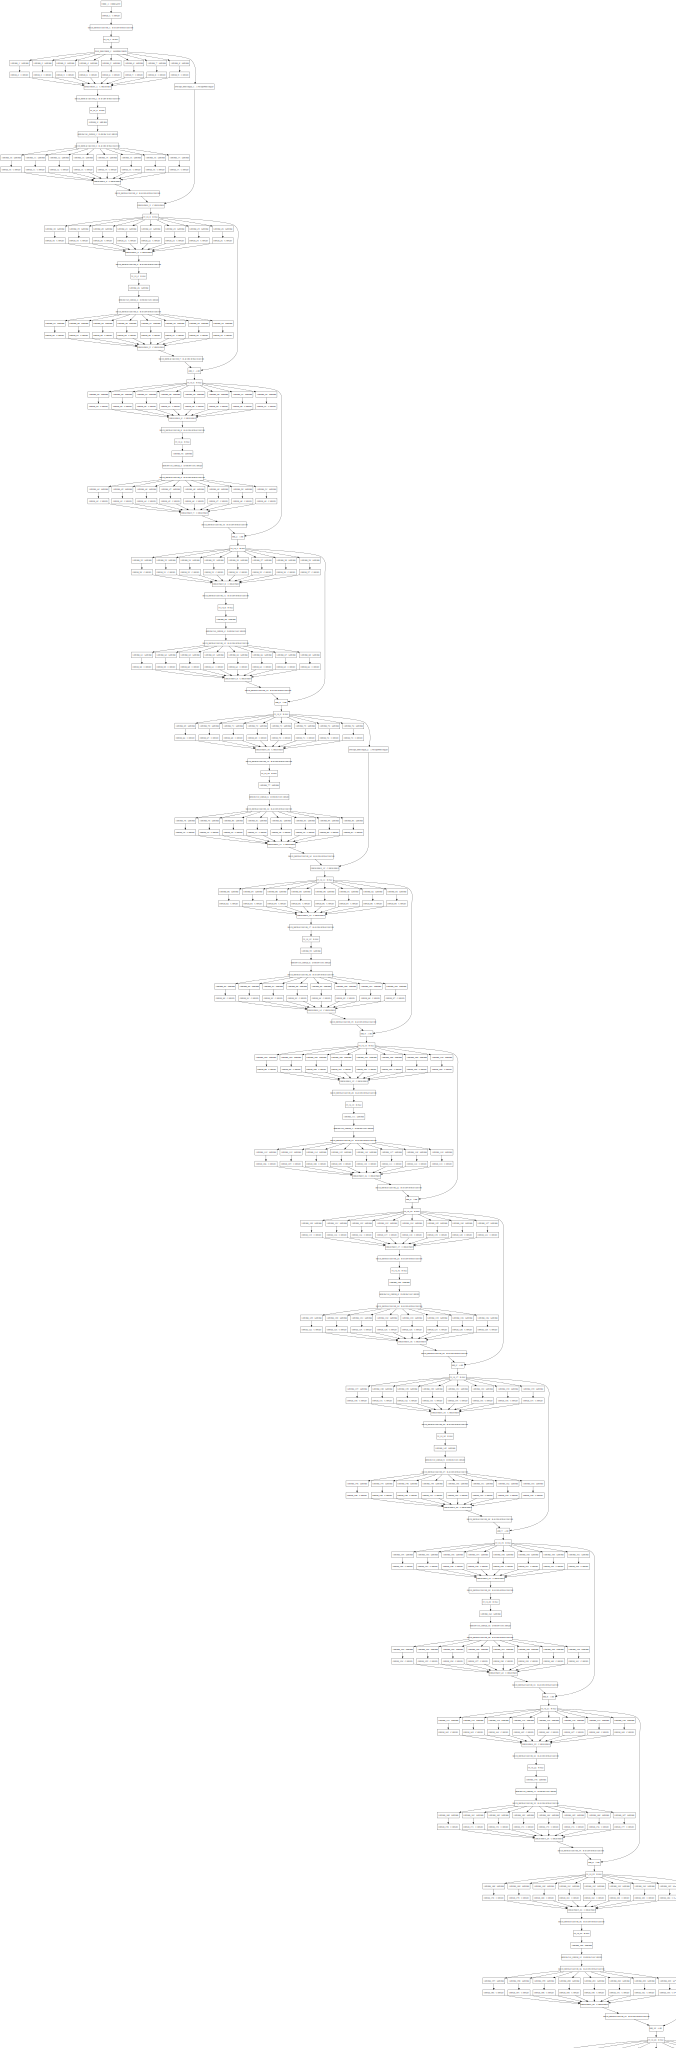

In [22]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [24]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/50
213/213 [==============================] - 542s 3s/step - loss: 1.5258 - acc: 0.5906 - val_loss: 1.9014 - val_acc: 0.2491
Epoch 2/50
213/213 [==============================] - 506s 2s/step - loss: 1.2293 - acc: 0.6421 - val_loss: 3.9451 - val_acc: 0.2624
Epoch 3/50
213/213 [==============================] - 492s 2s/step - loss: 1.1360 - acc: 0.6738 - val_loss: 1.9891 - val_acc: 0.3274
Epoch 4/50
213/213 [==============================] - 512s 2s/step - loss: 0.9478 - acc: 0.6923 - val_loss: 1.0583 - val_acc: 0.5274
Epoch 5/50
213/213 [==============================] - 508s 2s/step - loss: 0.7971 - acc: 0.7309 - val_loss: 8.5666 - val_acc: 0.3809
Epoch 6/50
213/213 [==============================] - 483s 2s/step - loss: 0.7373 - acc: 0.7425 - val_loss: 3.8179 - val_acc: 0.4178

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
213/213 [==============================] - 527s 2s/step - loss: 0.5032 - acc: 0.8016 - val_loss: 1.4003 - val

In [25]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.426415  ;  loss = 5.246200 


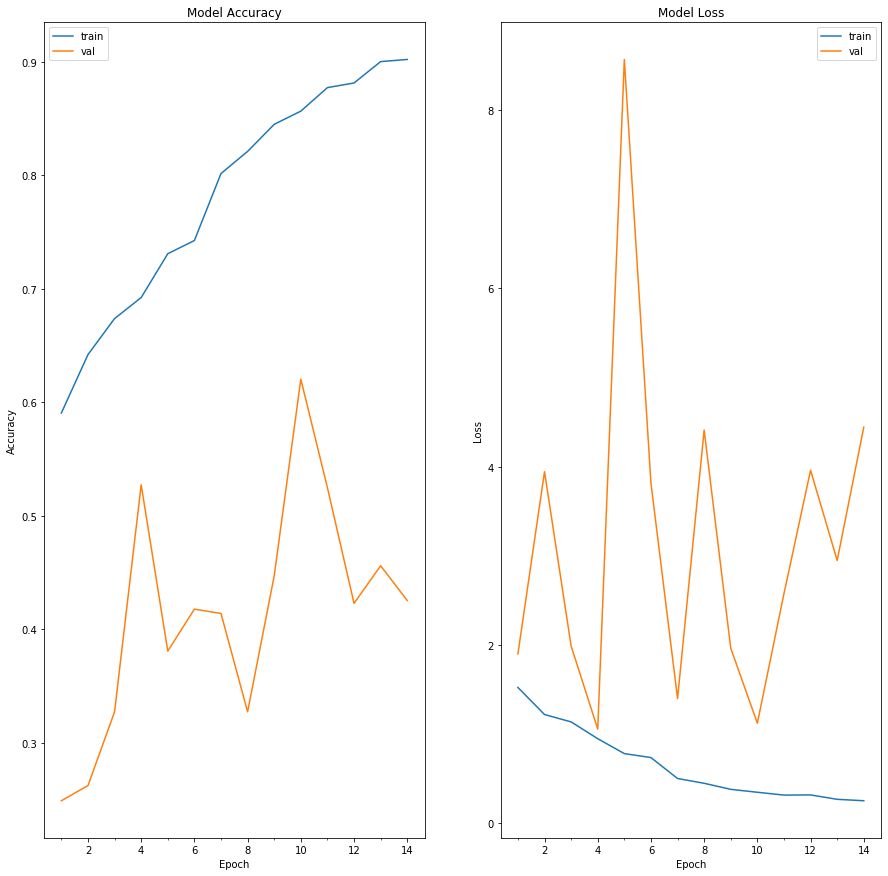

In [26]:
def plot_model_history(model_history, accuracy='acc', val_accuracy='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,15))
    axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
    axs[0].plot(range(1,len(model_history.history[val_accuracy])+1),model_history.history[val_accuracy])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
df1['category'] =df1['category'].replace({ 'c1':0,'c2':1,'c3':2,'c4':3})
Y_val=df1['category']
Y_val =Y_val.replace({ 0:'0', 1:'1',2:'2',3:'3'})
one_hot = MultiLabelBinarizer()
Y_val = one_hot.fit_transform(Y_val)
Y_val = [ np.argmax(t) for t in Y_val ]

In [28]:
y_pred =  model.predict_generator(validation_generator)
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)
y_final = [ np.argmax(t) for t in y_final ]

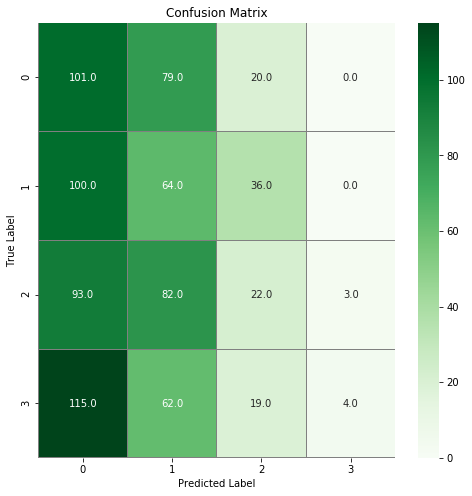

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [30]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1','2','3'])

print(report)

              precision    recall  f1-score   support

           0       0.25      0.51      0.33       200
           1       0.22      0.32      0.26       200
           2       0.23      0.11      0.15       200
           3       0.57      0.02      0.04       200

    accuracy                           0.24       800
   macro avg       0.32      0.24      0.20       800
weighted avg       0.32      0.24      0.20       800



In [31]:
test_filenames = os.listdir("/home/shiv/Desktop/tob_train_extra")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [32]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/shiv/Desktop/tob_train_extra", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames.


In [33]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [34]:
test_df['category'] = np.argmax(predict, axis=-1)

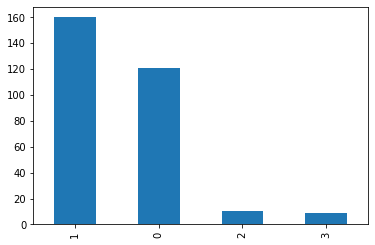

In [35]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'c1': 0, 'c2': 1,'c3': 2,'c4': 3})
test_df['category'].value_counts().plot.bar()

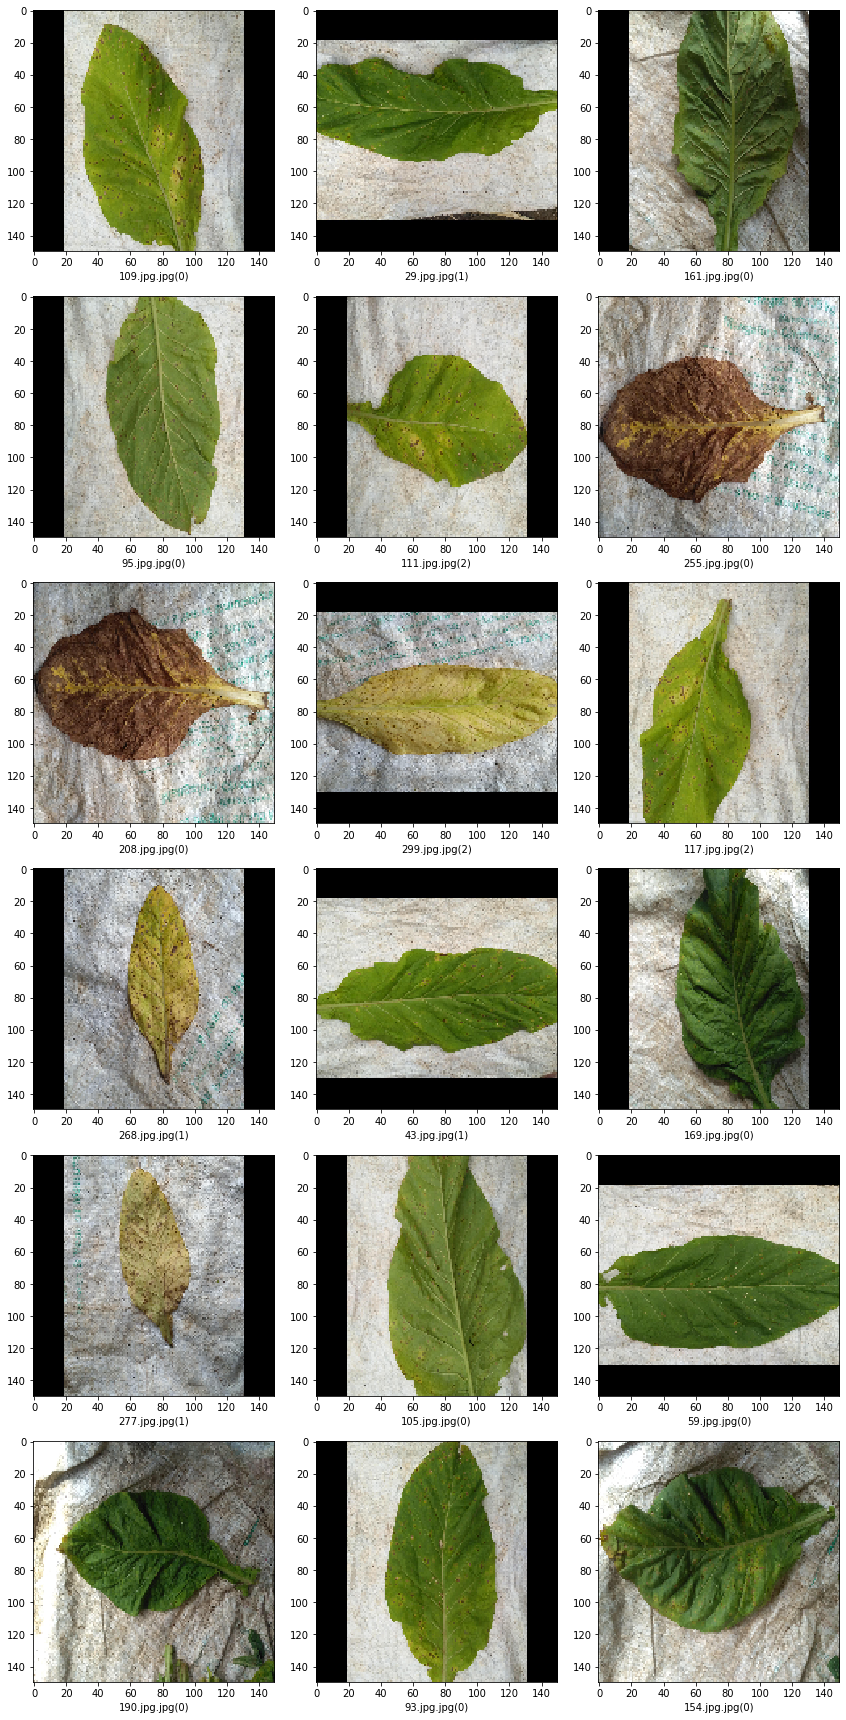

In [36]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/home/shiv/Desktop/tob_train_extra/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [37]:
import tensorflow as tf
tf.reset_default_graph()
K.clear_session()

# Resnet Implementation

In [39]:
def resnet(input_shape, n_classes):
  
  def conv_bn_rl(x, f, k=1, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
  
  
  def identity_block(tensor, f):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, tensor])
    output = ReLU()(x)
    return output
  
  
  def conv_block(tensor, f, s):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, s)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(4*f, 1, strides=s)(tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    output = ReLU()(x)
    return output
  
  
  def resnet_block(x, f, r, s=2):
    x = conv_block(x, f, s)
    for _ in range(r-1):
      x = identity_block(x, f)
    return x
    
  
  input = Input(input_shape)
  
  x = conv_bn_rl(input, 64, 7, 2)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = resnet_block(x, 64, 3, 1)
  x = resnet_block(x, 128, 4)
  x = resnet_block(x, 256, 6)
  x = resnet_block(x, 512, 3)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [41]:
input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS);
n_classes = 4;
model = resnet(input_shape,n_classes);
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 75, 75, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

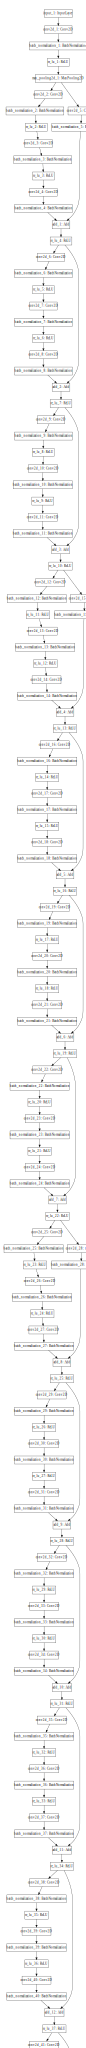

In [42]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [45]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
213/213 [==============================] - 482s 2s/step - loss: 1.4513 - acc: 0.5287 - val_loss: 193.3298 - val_acc: 0.3497
Epoch 2/50
213/213 [==============================] - 511s 2s/step - loss: 0.9083 - acc: 0.6396 - val_loss: 0.9444 - val_acc: 0.5338
Epoch 3/50
213/213 [==============================] - 529s 2s/step - loss: 0.7430 - acc: 0.7133 - val_loss: 10.7902 - val_acc: 0.5631
Epoch 4/50
213/213 [==============================] - 502s 2s/step - loss: 0.7617 - acc: 0.7077 - val_loss: 5.4696 - val_acc: 0.3439
Epoch 5/50
213/213 [==============================] - 500s 2s/step - loss: 0.7307 - acc: 0.7253 - val_loss: 3.4084 - val_acc: 0.4446

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
213/213 [==============================] - 517s 2s/step - loss: 0.5648 - acc: 0.7840 - val_loss: 1.7638 - val_acc: 0.5083
Epoch 7/50
213/213 [==============================] - 493s 2s/step - loss: 0.5414 - acc: 0.7761 - val_loss: 0.3697 - v

In [46]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.740880  ;  loss = 0.702938 


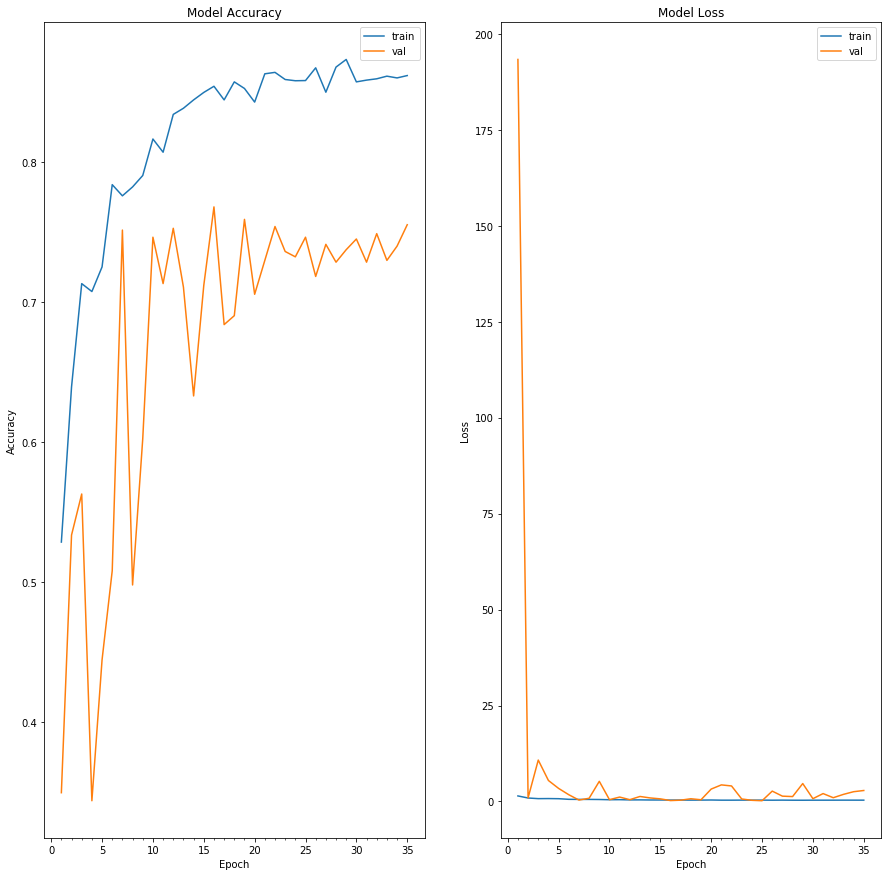

In [47]:
def plot_model_history(model_history, accuracy='acc', val_accuracy='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,15))
    axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
    axs[0].plot(range(1,len(model_history.history[val_accuracy])+1),model_history.history[val_accuracy])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [67]:
df1['category'] =df1['category'].replace({ 'c1':0,'c2':1,'c3':2,'c4':3})

In [68]:
Y_val=df1['category']

In [69]:
from sklearn.preprocessing import MultiLabelBinarizer
Y_val =Y_val.replace({ 0:'0', 1:'1',2:'2',3:'3'})
one_hot = MultiLabelBinarizer()
Y_val = one_hot.fit_transform(Y_val)
Y_val = [ np.argmax(t) for t in Y_val ]

In [70]:
y_pred =  model.predict_generator(validation_generator)

In [71]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)
y_final = [ np.argmax(t) for t in y_final ]

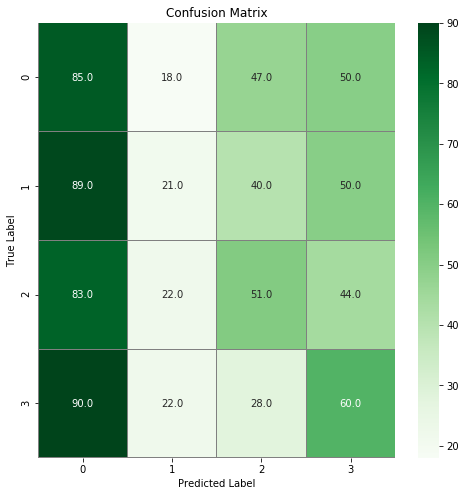

In [72]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [73]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1','2','3'])

print(report)

              precision    recall  f1-score   support

           0       0.24      0.42      0.31       200
           1       0.25      0.10      0.15       200
           2       0.31      0.26      0.28       200
           3       0.29      0.30      0.30       200

    accuracy                           0.27       800
   macro avg       0.27      0.27      0.26       800
weighted avg       0.27      0.27      0.26       800



In [74]:
test_filenames = os.listdir("/home/shiv/Desktop/tob_train_extra")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [75]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/shiv/Desktop/tob_train_extra", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames.


In [76]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [77]:
test_df['category'] = np.argmax(predict, axis=-1)

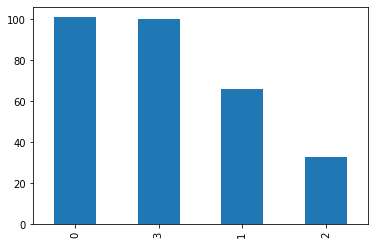

In [78]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'c1': 0, 'c2': 1,'c3': 2,'c4': 3})
test_df['category'].value_counts().plot.bar()

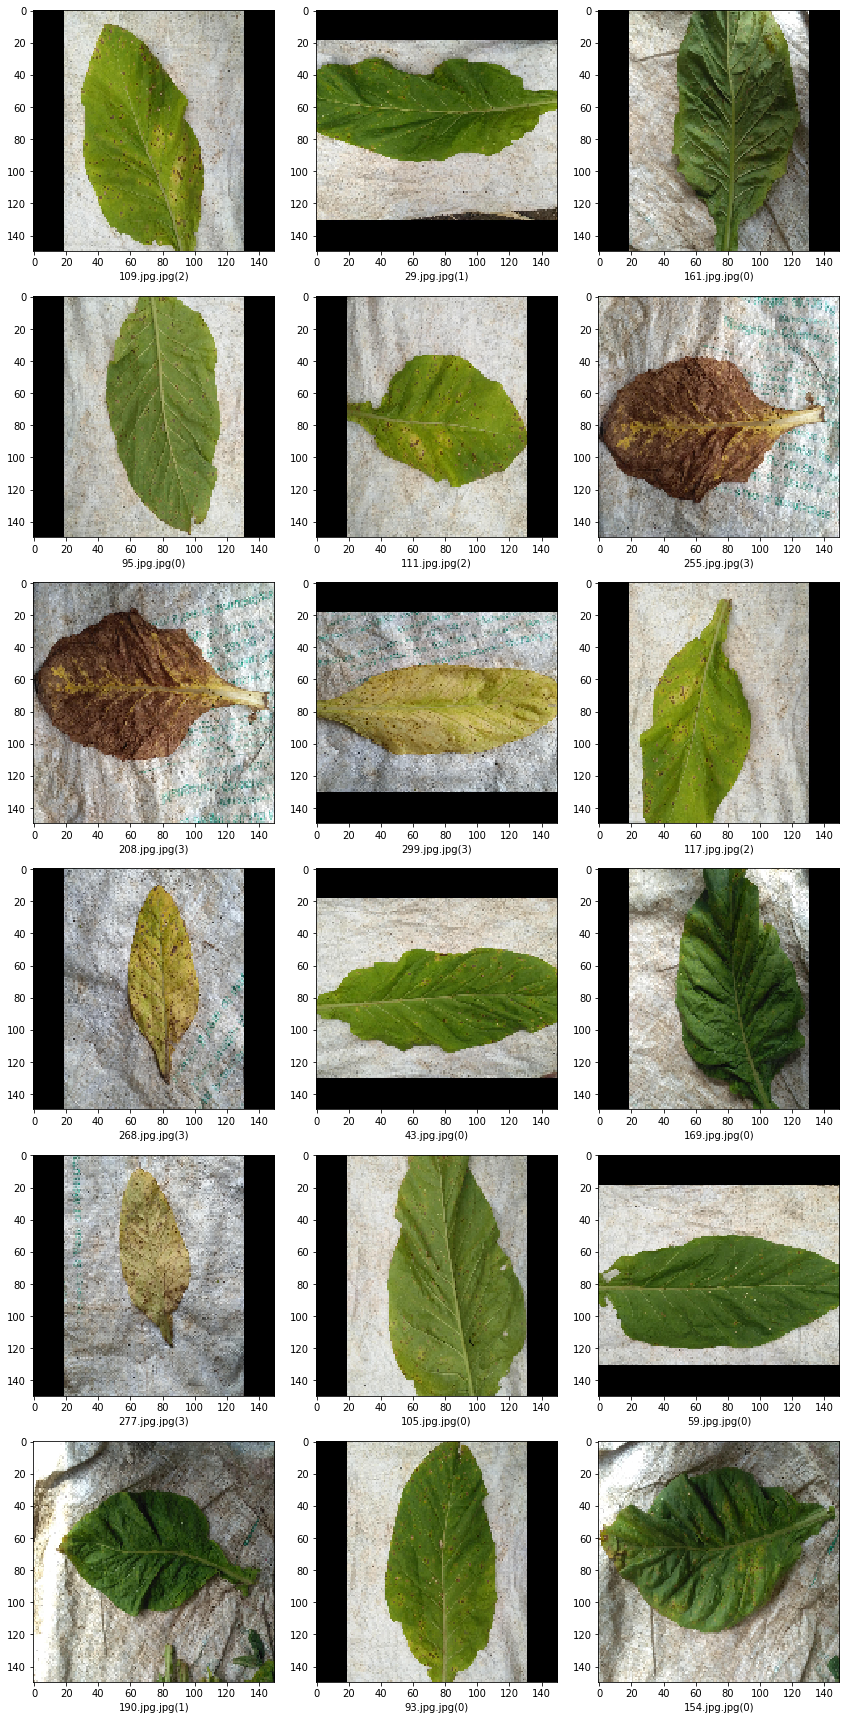

In [79]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/home/shiv/Desktop/tob_train_extra/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()